In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [51]:
players_data = pd.read_csv("../../Data/40_point_breaktrough/youngest_to_40.csv")
splits = players_data.Player.str.split('\\')
names = [name for name, url in splits.tolist()]
players_data.Player = names

In [52]:
age = players_data.Age.tolist()
age_numbers = [player_age.split("-")[0] + str(float(float(player_age.split("-")[1])/ 365.0))[1:] for player_age in age]
age_numbers = [player_age[:6] if len(player_age) > 5 else player_age for player_age in age_numbers]
players_data.Age = age_numbers

In [53]:
age = players_data.Age.tolist()
only_years = [player_age.split(".")[0] for player_age in age]
players_data['Years'] = only_years

In [54]:
sorted_df = players_data.sort_values(by=['Player', 'Age'])
unique_players = sorted_df.drop_duplicates(subset=['Player'], keep='first').copy()

In [55]:
dates = unique_players.Date
seasons = [date.split("-")[0] + "-" + str(int(date.split("-")[0])+1)[2:] if int(date.split("-")[1]) >= 10 else 
           str(int(date.split("-")[0])-1) + "-" + date.split("-")[0][2:] for date in dates]
unique_players['Season'] = seasons

In [56]:
players, seasons = unique_players.Player, unique_players.Season
player_seasons = [player + " " + season[2:] for (player, season) in zip(players, seasons)]
player_seasons
unique_players['ScatterString'] = player_seasons

In [57]:
from nba_py import player
from adjustText import adjust_text

In [58]:

#player_name, season, player_season = "Aaron Gordon", "2017-18", "Gordon 17-18"
def split_dataset_previous_current(player_name, season, player_season):
    name, surname = player_name.split(" ")[0], player_name.split(" ")[1]
    if name == "J.R.":
        name = "JR"
    player_id = player.get_player(name, surname)
    player_career = player.PlayerCareer(player_id)
    player_stats = player_career.regular_season_totals()
    season_stats = player_stats.loc[player_stats.SEASON_ID == season]
    if len(season_stats) > 1:
        # get total stats if he was traded
        season_stats = player_stats.loc[(player_stats.SEASON_ID == season) & (player_stats.TEAM_ID == 0)]
    previous_season = int(season.split("-")[0])-1
    previous_season_string = str(previous_season) + "-" + season.split("-")[0][2:]
    is_rookie = True
    if player_stats.iloc[0, 1] != season:        
        is_rookie = False
        previous_season_stats = player_stats.loc[player_stats.SEASON_ID == previous_season_string]    
        if len(previous_season_stats) > 1:
            # get total stats if he was traded
            previous_season_stats = player_stats.loc[(player_stats.SEASON_ID == previous_season_string) & (player_stats.TEAM_ID == 0)]
    if is_rookie:
        pts_changed = 0
    else:
        pts_changed = season_stats.iloc[0].PTS - previous_season_stats.iloc[0].PTS
    season_stats.loc[:, "PTSChange"] = pts_changed
    season_stats.loc[:, "PlayerSeason"] = player_season
    return season_stats

In [59]:
index = 0
curr_df = split_dataset_previous_current(unique_players.iloc[index,:].Player, unique_players.iloc[index, :].Season, unique_players.iloc[index, :].ScatterString)
curr_df.reset_index()
for i in range(1, len(unique_players)):
    curr_player = unique_players.iloc[i, :]
    player_name, season, string = curr_player.Player, curr_player.Season, curr_player.ScatterString
    curr = split_dataset_previous_current(player_name, season, string)
    curr_df = curr_df.append(curr, ignore_index=True)

In [64]:
plt.style.use('fivethirtyeight')

In [65]:
only_non_rookies = curr_df.drop(curr_df[curr_df.PTSChange == 0.0].index)

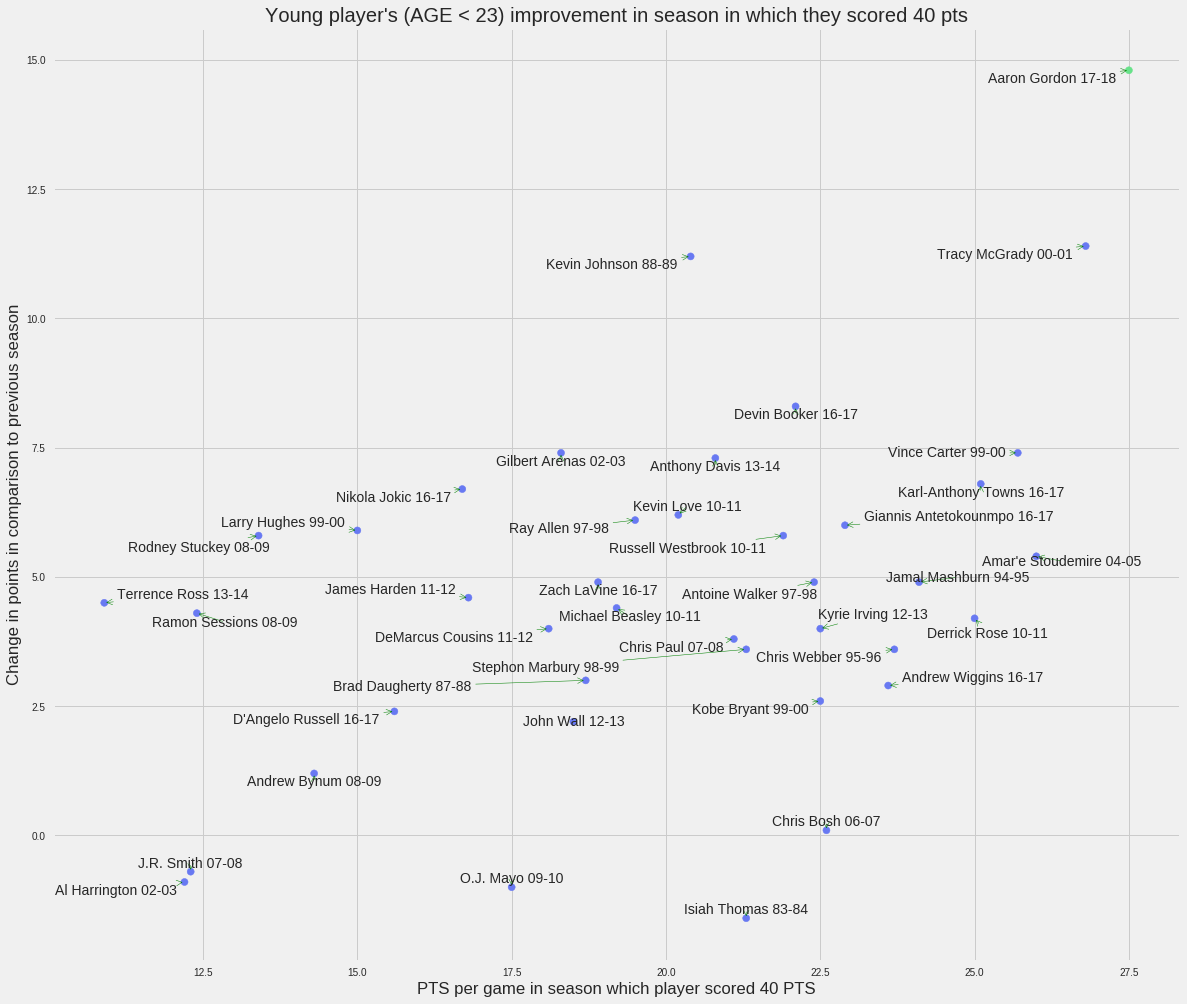

In [76]:
plt.figure(figsize=(18, 16))
texts = []
colors = []
color_blue = "#6879f2"
color_gordon = "#67e289"
for i in range(len(only_non_rookies)):
    texts.append(plt.text(
              only_non_rookies.iloc[i].PTS, 
              only_non_rookies.iloc[i].PTSChange, 
              s = only_non_rookies.iloc[i].PlayerSeason))
    if only_non_rookies.iloc[i].PlayerSeason == 'Aaron Gordon 17-18':
        colors.append(color_gordon)
    else:
        colors.append(color_blue)
    
plt.scatter(only_non_rookies.PTS, only_non_rookies.PTSChange, c = colors)
adjust_text(texts,expand_points=(1.2, 1.2), expand_text=(1.0, 1.4), autoalign='auto', arrowprops=dict(arrowstyle="->", color='g', lw=0.5))

plt.xlabel("PTS per game in season which player scored 40 PTS")
plt.ylabel("Change in points in comparison to previous season")
plt.title("Young player's (AGE < 23) improvement in season in which they scored 40 pts")